This project was authored by Eli Sinai and Daniel Meir Karl.







## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as skmetrics
from sklearn.manifold import TSNE
import joblib
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG19, resnet
from tensorflow.keras.models import Model
import scipy
from skimage.feature.peak import peak_local_max
from google.colab.data_table import DataTable as data_table
import PIL
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from PIL import Image
import random


Mounted at /content/drive


# Load data


> Define the directories in which the train, validation and test datasets are.


> convert the rawdata into a pandas
dataframe

In [ ]:
data_dir = Path("/content/drive/MyDrive/chest_xray")

train_dir = Path(data_dir, "train")
test_dir = Path(data_dir, "test")
validation_dir = Path(data_dir, "val")

labels = ["NORMAL", "PNEUMONIA"]

In [ ]:
def load_dataframe(data_dir: Path, labels: list[str]):
    img_files = []
    classes = []
    class_names = []
    for label_path in data_dir.iterdir():
        if label_path.is_dir():
            files = list(label_path.glob("*.jpeg"))
            img_files.extend(files)

            img_class = labels.index(label_path.name)
            classes.extend([img_class] * len(files))
            class_names.extend([label_path.name] * len(files))

    img_files = pd.Series(img_files, name="img_path", dtype="object")
    classes = pd.Series(classes, name="label_num")
    class_names = pd.Series(class_names, name="label")
    return pd.concat([img_files, classes, class_names], axis=1)

# data_table(df_train, include_index=False, num_rows_per_page=25)

In [ ]:
df_train = load_dataframe(train_dir, labels)
df_test = load_dataframe(test_dir, labels)
data_table(df_test, include_index=False, num_rows_per_page=10)

## Build datasets

In [ ]:
IMG_SIZE = (280, 280)
INPUT_SHAPE = (*IMG_SIZE, 3)

> fetching the training, validation, test datasets shuffled

In [ ]:
def build_datasets_from_directories(
    train: Path, validation: Path, test: Path, label_mode="int"
) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    config = {
        "image_size": IMG_SIZE,
        "batch_size": 32,
        "label_mode": label_mode,
        "shuffle": True,
    }

    print("---------------Train-----------------")

    train_dataset = image_dataset_from_directory(train, **config)

    num_train_val_split = len(train_dataset) // 4

    val_from_train = train_dataset.take(num_train_val_split)
    train_dataset = train_dataset.skip(num_train_val_split)

    print("---------------Validation-----------------")

    val_dataset = image_dataset_from_directory(validation, **config)
    val_dataset = val_dataset.concatenate(val_from_train)

    print("---------------Test-----------------")

    test_dataset = image_dataset_from_directory(test, **config)

    return train_dataset, val_dataset, test_dataset


train_ds, val_ds, test_ds = build_datasets_from_directories(
    train_dir, validation_dir, test_dir
)

---------------Train-----------------
Found 5216 files belonging to 2 classes.
---------------Validation-----------------
Found 16 files belonging to 2 classes.
---------------Test-----------------
Found 624 files belonging to 2 classes.


## Building a data augmentation layers
<br>
The purpose of this is to grab images from the directories in a diffrent types of variations.
<br>
Like: rotated image, zoom on the center, rescaling the pixels between (0,1)
<br>
In addition, we crop the images s.t. the model will focus only on the chest itself.

In [ ]:
CNR_IMG_INPUT_SHAPE = (180, 180, 3)

In [ ]:
resize_scale = keras.Sequential(
    [layers.Resizing(*IMG_SIZE), layers.Rescaling(1.0 / 255)]
)

scale = layers.Rescaling(1.0 / 255)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.05),
        layers.RandomZoom(height_factor=-0.1, width_factor=-0.1),
    ]
)


def central_crop_datasets(
    train_dataset: tf.data.Dataset,
    val_dataset: tf.data.Dataset,
    test_dataset: tf.data.Dataset,
    central_fraction: float = 0.72,
) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:

    cnr_train_ds = train_dataset.map(
        lambda image, label: (tf.image.central_crop(image, central_fraction), label)
    )

    cnr_val_ds = val_dataset.map(
        lambda image, label: (tf.image.central_crop(image, central_fraction), label)
    )
    cnr_test_ds = test_dataset.map(
        lambda image, label: (tf.image.central_crop(image, central_fraction), label)
    )

    return cnr_train_ds, cnr_val_ds, cnr_test_ds


cnr_train_ds, cnr_val_ds, cnr_test_ds = central_crop_datasets(train_ds, val_ds, test_ds, central_fraction=0.64)

## Data Visualization

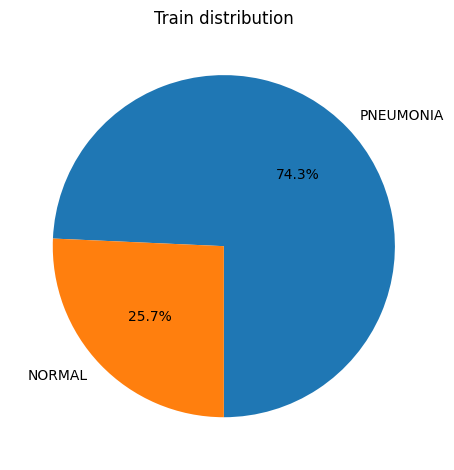

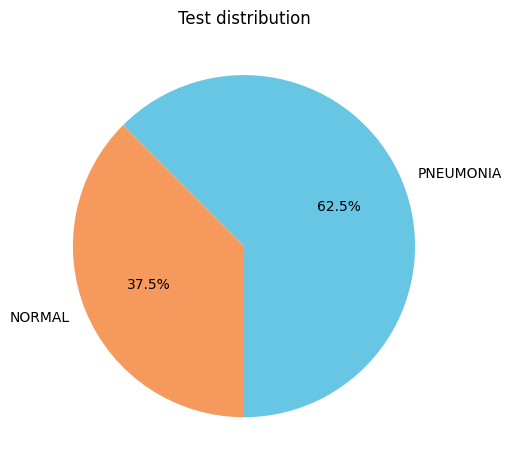

In [ ]:
def count_visualization(labels: pd.Series):
    count_labels = labels.value_counts()
    sns.set_palette(sns.color_palette(["#67C6E3", "#F6995C"]))
    plt.pie(
        x=count_labels, labels=count_labels.index, autopct="%1.1f%%", startangle=270
    )
    plt.tight_layout()
    plt.show()

plt.title("Train distribution")
count_visualization(df_train["label"])
plt.title("Test distribution")
count_visualization(df_test["label"])

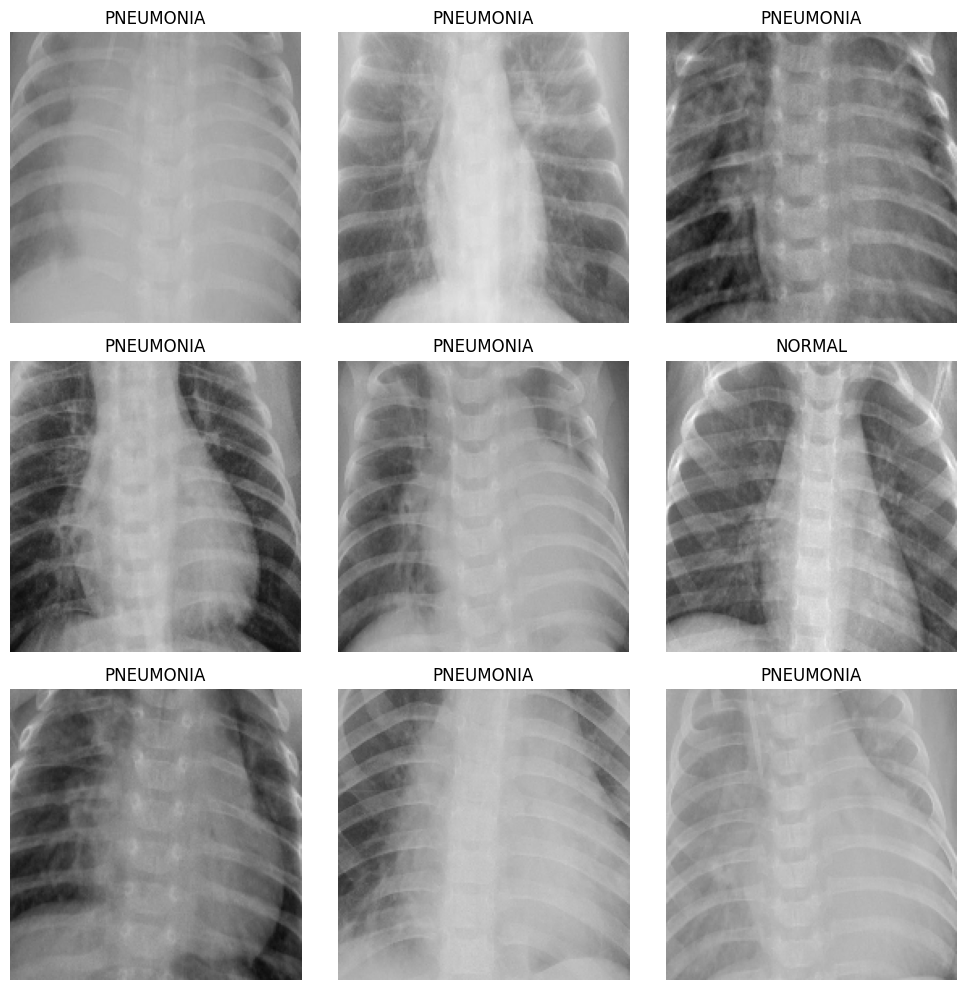

In [ ]:
def visualize_random_batch(labels: list[str], dataset: tf.data.Dataset):
    plt.figure(figsize=(10, 10))
    for images_batch, labels_batch in dataset.take(1):
        images_batch = scale(images_batch)
        for i in range(9):
            p = plt.subplot(3, 3, i + 1)
            p.imshow(images_batch[i])
            if len(labels) > 2:
                p.set_title(labels[tf.argmax(labels_batch[i])])
            else:
                p.set_title(labels[labels_batch[i]])
            p.axis("off")

    plt.tight_layout()
    plt.show()


visualize_random_batch(labels, cnr_test_ds)

In [ ]:
def visualize_predicted_random_batch(labels: list[str], dataset: tf.data.Dataset, model: keras.Model):
    plt.figure(figsize=(10, 10))
    for images_batch, labels_batch in dataset.take(1):

        predictions = np.squeeze(model.predict(images_batch[:9], verbose=0))
        binary_predictions = (predictions > 0.6).astype("uint8")

        images_batch = scale(images_batch)
        for i in range(9):
            p = plt.subplot(3, 3, i + 1)
            p.imshow(images_batch[i])
            if len(labels) > 2:
                p.set_title(f"pred: {labels[binary_predictions[i]]} real: {labels[tf.argmax(labels_batch[i])]}")
            else:
                p.set_title(f"pred: {labels[binary_predictions[i]]} real: {labels[labels_batch[i]]} \npercent for sick chest: {round(predictions[i] * 100, 2)}%")
            p.axis("off")

    plt.tight_layout()
    plt.show()

> Implemented a generic function that takes a model history of training and plots the loss/validation_loss, accuracy/validation_accuracy.

In [ ]:
def visualize_model_training_history(history):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history.history["accuracy"][1:], label="accuracy")
    plt.plot(history.history["val_accuracy"][1:], label="val_accuracy")
    plt.legend()
    plt.title("accuracy eval")

    plt.subplot(2, 2, 2)
    plt.plot(history.history["loss"][1:], label="loss")
    plt.plot(history.history["val_loss"][1:], label="val_loss")
    plt.legend()
    plt.title("loss eval")

    plt.show()

# Building the Binary model

In the first problem we need to classify between 2 categories (healthy, sick).<br>
We employed the **VGG19** model for transfer learning, utilizing fine-tuning.<br>
This process involved taking the base model of VGG19, incorporating its pre-trained weights, and augmenting it with additional dense layers along with dropout regularization.<br> Subsequently, we trained all the model's weights, starting from the initial weights derived from VGG19.<br> For optimization, we utilized Binary Cross Entropy loss and the RMSprop optimizer with a learning rate set to 0.0001, employing Exponential Decay.<br> This decay mechanism gradually reduces the learning rate over time as training progresses.

This attempt was successful, achieving an accuracy of 98% on the validation set and **85%** on the test set.



In [ ]:
base2 = VGG19(include_top=False, weights="imagenet", input_shape=CNR_IMG_INPUT_SHAPE)
base2.trainable = True

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
base2.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
def get_binary_model() -> keras.Model:
    model = Sequential(
        [
            layers.Input(shape=CNR_IMG_INPUT_SHAPE),
            data_augmentation,
            base2,  # base model of the vgg19
            layers.Dropout(0.2),
            layers.GlobalAveragePooling2D(), # using GlobalAveragePooling2D instead of flatten, useful for the heatmap
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    start_lr = 0.0001
    learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
        start_lr, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model.compile(
        optimizer=optimizers.RMSprop(learning_rate_schedule),
        loss=losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )
    return model


binary_model = get_binary_model()

In [ ]:
binary_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [ ]:
# stop if there is no improvemnet on the train
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# fit with the cropped images, for 200 epochs
history_binary = binary_model.fit(
    cnr_train_ds,
    epochs=200,
    initial_epoch=0,
    validation_data=cnr_val_ds,
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/200
123/123 [==============================] - 1512s 8s/step - loss: 0.6988 - accuracy: 0.7201 - val_loss: 0.4158 - val_accuracy: 0.7387
Epoch 2/200
123/123 [==============================] - 77s 506ms/step - loss: 0.3802 - accuracy: 0.8199 - val_loss: 0.2435 - val_accuracy: 0.8938
Epoch 3/200
123/123 [==============================] - 82s 549ms/step - loss: 0.2738 - accuracy: 0.8928 - val_loss: 1.1697 - val_accuracy: 0.5881
Epoch 4/200
123/123 [==============================] - 82s 556ms/step - loss: 0.2108 - accuracy: 0.9210 - val_loss: 2.2403 - val_accuracy: 0.7349
Epoch 5/200
123/123 [==============================] - 82s 553ms/step - loss: 0.1852 - accuracy: 0.9424 - val_loss: 0.3483 - val_accuracy: 0.7786
Epoch 6/200
123/123 [==============================] - 85s 570ms/step - loss: 0.1353 - accuracy: 0.9514 - val_loss: 0.2475 - val_accuracy: 0.9119
Epoch 7/200
123/123 [==============================] - 82s 552ms/step - loss: 0.1116 - accuracy: 0.9603 - val_loss: 0.1827 - 

In [ ]:
# save the model to a file after training
binary_model.save("/content/drive/MyDrive/University/DL-Project/models/binary_model_VGG19_finetuned_final.keras")

In [ ]:
# load the model, there is no need to train again after saving the weights
binary_model.load_weights("/content/drive/MyDrive/Final_Submission_DL/binary_model_VGG19_finetuned_final.keras")

In [ ]:
# evaluate the model
binary_model.evaluate(cnr_test_ds, verbose=1)

20/20 [==============================] - 110s 3s/step - loss: 0.8295 - accuracy: 0.8478


[0.8295082449913025, 0.8477563858032227]

> Lets visualize some test images with their real label, predicted label and the probability for a sick chest.

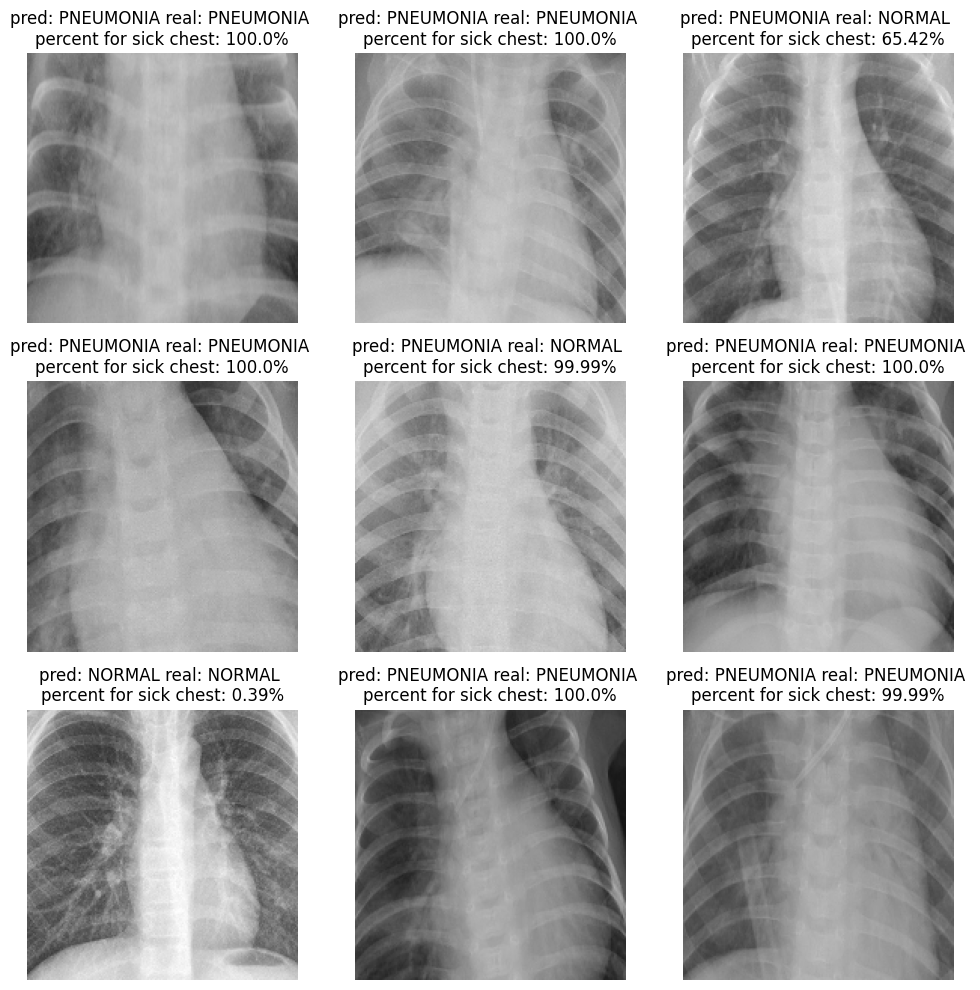

In [ ]:
visualize_predicted_random_batch(labels, cnr_test_ds, binary_model)

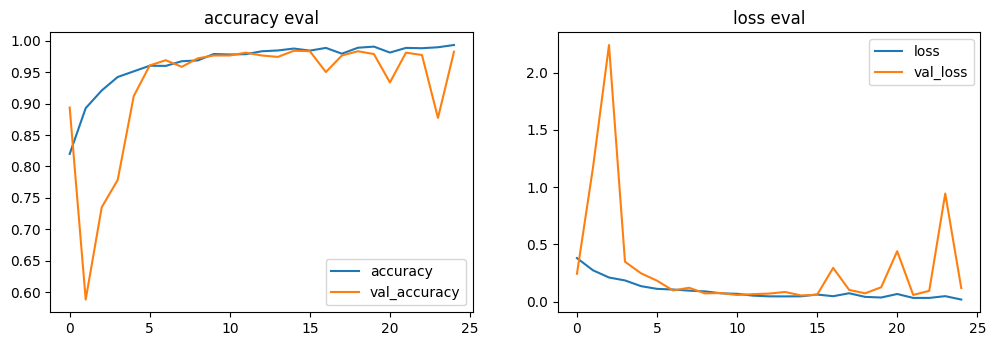

In [ ]:
visualize_model_training_history(history_binary)

# Explainability for binary model
We opted the **Visualizing patches that maximizes activation** technique, also called Heatmap technique, which allows us to infer the pixels that were most influential in making the prediction.
<br> This technique  facilitate interpretability by identifying the specific features or patterns that contribute most significantly to the model's predictions.

In [ ]:
def plot_heatmap(img: np.ndarray) -> np.ndarray:

    last_layer_weights = binary_model.layers[-1].get_weights()[0]  # Prediction layer

    # Get weights for the predicted class
    last_layer_weights_for_pred = last_layer_weights[:, :]

    # Get output from the last conv. layer
    last_conv_model = Model(base2.input, base2.get_layer("block5_conv4").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis, :, :, :], verbose=0)
    last_conv_output = np.squeeze(last_conv_output)

    # Upsample/resize the last conv. output to the same size as the original image
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (img.shape[0] / last_conv_output.shape[0], img.shape[1] / last_conv_output.shape[1], 1), order=1)

    # Calculate heatmap
    heat_map = np.dot(upsampled_last_conv_output.reshape((-1, 512)),
                      last_layer_weights_for_pred).reshape(img.shape[0], img.shape[1])

    # Set heatmap values to 0 where the original image is dark
    heat_map[img[:, :, 0] == 0] = 0

    return heat_map

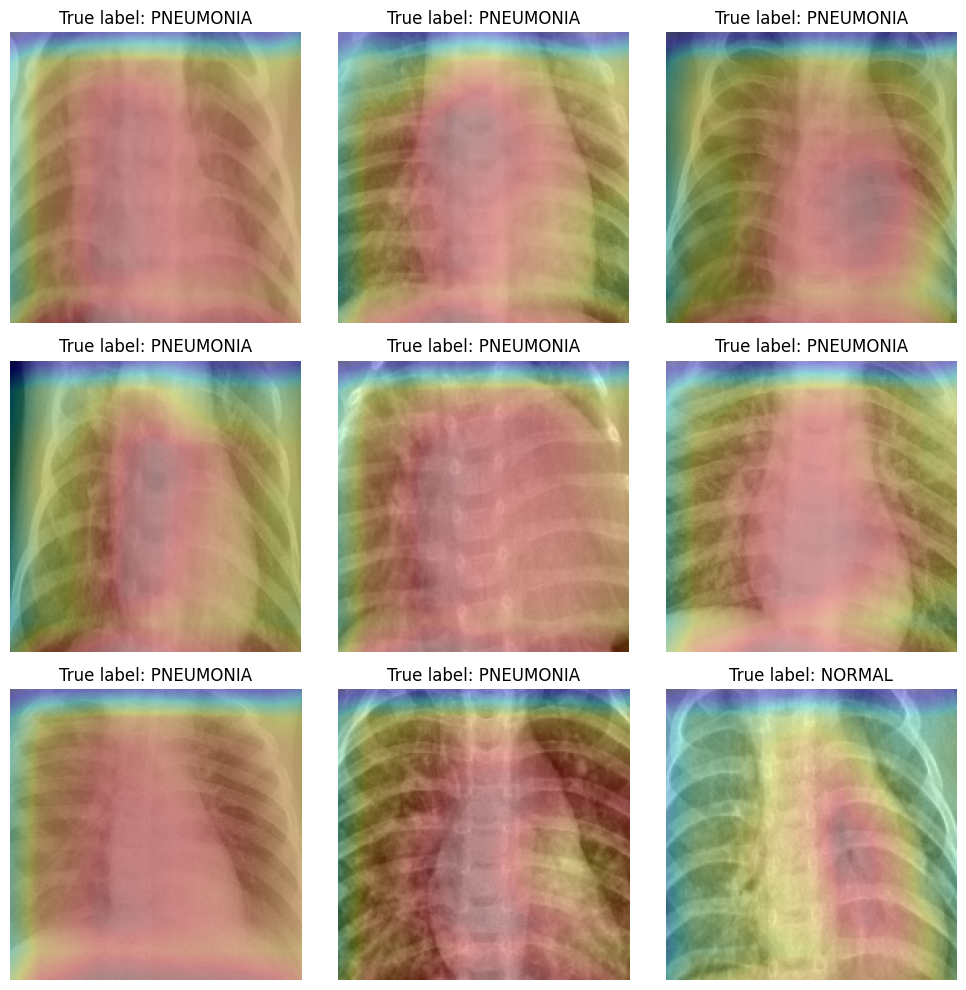

In [ ]:
def visualize_random_batch_test_heatmap(labels: list[str], dataset: tf.data.Dataset, model: keras.Model):
    plt.figure(figsize=(10, 10))
    for images_batch, labels_batch in dataset.take(1):
        images_batch = scale(images_batch)
        for i in range(9):
            p = plt.subplot(3, 3, i + 1)

            img_np = images_batch[i].numpy()

            heat_map_img = plot_heatmap(images_batch[i])

            p.imshow(img_np.astype('float32').reshape(images_batch[i].shape[0], images_batch[i].shape[1], 3))
            p.imshow(heat_map_img, cmap='jet', alpha=0.30)
            pred = model.predict(np.expand_dims(images_batch[i], axis=0), verbose=0)
            if len(labels) > 2:
                p.set_title(labels[tf.argmax(labels_batch[i])])
            else:
                p.set_title("True label: "+labels[labels_batch[i]])
            p.axis("off")

    plt.tight_layout()
    plt.show()

visualize_random_batch_test_heatmap(labels, cnr_test_ds, binary_model)

# Building the multiclass model
In the multiclass probelm, we utilized the **RESNET101** architecture for feature extraction and fine-tuning to address our multi-class classification task. <br>
Additionally, we made adjustments to the learning rate, setting it to 0.001 and incorporating Exponential Decay.<br>
The accuracy was not perfect, but we achieved over 80 percent accuracy on the test set.

In [ ]:
def prepare_multiclass_classification(new_dir: Path, data_dir: Path) -> tuple[Path, Path, Path]:
    new_data_dir = Path(new_dir, data_dir.name)
    # print(new_data_dir)
    train_dir = Path(new_data_dir, "train")
    val_dir = Path(new_data_dir, "val")
    test_dir = Path(new_data_dir, "test")

    if train_dir.exists() and val_dir.exists() and test_dir.exists():
        return train_dir, val_dir, test_dir

    train_b_dir = Path(train_dir, "BACTERIAL")
    train_b_dir.mkdir(exist_ok=True, parents=True)
    for path in Path(data_dir, "train", "PNEUMONIA").glob("*bacteria*.jpeg"):
        Path(train_b_dir, path.name).symlink_to(path.absolute())

    train_v_dir = Path(train_dir, "VIRAL")
    train_v_dir.mkdir(exist_ok=True, parents=True)
    for path in Path(data_dir, "train", "PNEUMONIA").glob("*virus*.jpeg"):
        Path(train_v_dir, path.name).symlink_to(path.absolute())

    val_b_dir = Path(val_dir, "BACTERIAL")
    val_b_dir.mkdir(exist_ok=True, parents=True)
    for path in Path(data_dir, "val", "PNEUMONIA").glob("*bacteria*.jpeg"):
        Path(val_b_dir, path.name).symlink_to(path.absolute())

    val_v_dir = Path(val_dir, "VIRAL")
    val_v_dir.mkdir(exist_ok=True, parents=True)
    for path in Path(data_dir, "val", "PNEUMONIA").glob("*virus*.jpeg"):
        Path(val_v_dir, path.name).symlink_to(path.absolute())

    test_b_dir = Path(test_dir, "BACTERIAL")
    test_b_dir.mkdir(exist_ok=True, parents=True)
    for path in Path(data_dir, "test", "PNEUMONIA").glob("*bacteria*.jpeg"):
        Path(test_b_dir, path.name).symlink_to(path.absolute())

    test_v_dir = Path(test_dir, "VIRAL")
    test_v_dir.mkdir(exist_ok=True, parents=True)
    for path in Path(data_dir, "test", "PNEUMONIA").glob("*virus*.jpeg"):
        Path(test_v_dir, path.name).symlink_to(path.absolute())

    Path(train_dir, "NORMAL").symlink_to(
        Path(data_dir, "train", "NORMAL").absolute(), target_is_directory=True
    )
    Path(val_dir, "NORMAL").symlink_to(
        Path(data_dir, "val", "NORMAL").absolute(), target_is_directory=True
    )
    Path(test_dir, "NORMAL").symlink_to(
        Path(data_dir, "test", "NORMAL").absolute(), target_is_directory=True
    )

    return train_dir, val_dir, test_dir


multi_train_dir, multi_val_dir, multi_test_dir = prepare_multiclass_classification(Path("chest_xrays_multi"), data_dir)

In [ ]:
CNR_IMG_MULTICLASS_INPUT_SHAPE = (202, 202, 3)

In [ ]:
multi_train_ds, multi_val_ds, multi_test_ds = build_datasets_from_directories(
    multi_train_dir, multi_val_dir, multi_test_dir, label_mode="categorical"
)
cnr_multi_train_ds, cnr_multi_val_ds, cnr_multi_test_ds = central_crop_datasets(
    multi_train_ds, multi_val_ds, multi_test_ds, central_fraction=0.72
)

---------------Train-----------------
Found 5216 files belonging to 3 classes.
---------------Validation-----------------
Found 16 files belonging to 3 classes.
---------------Test-----------------
Found 624 files belonging to 3 classes.


In [ ]:
multi_class_labels = ["BACTERIAL", "NORMAL", "VIRAL"]

In [ ]:
multi_test_ds.class_names

['BACTERIAL', 'NORMAL', 'VIRAL']

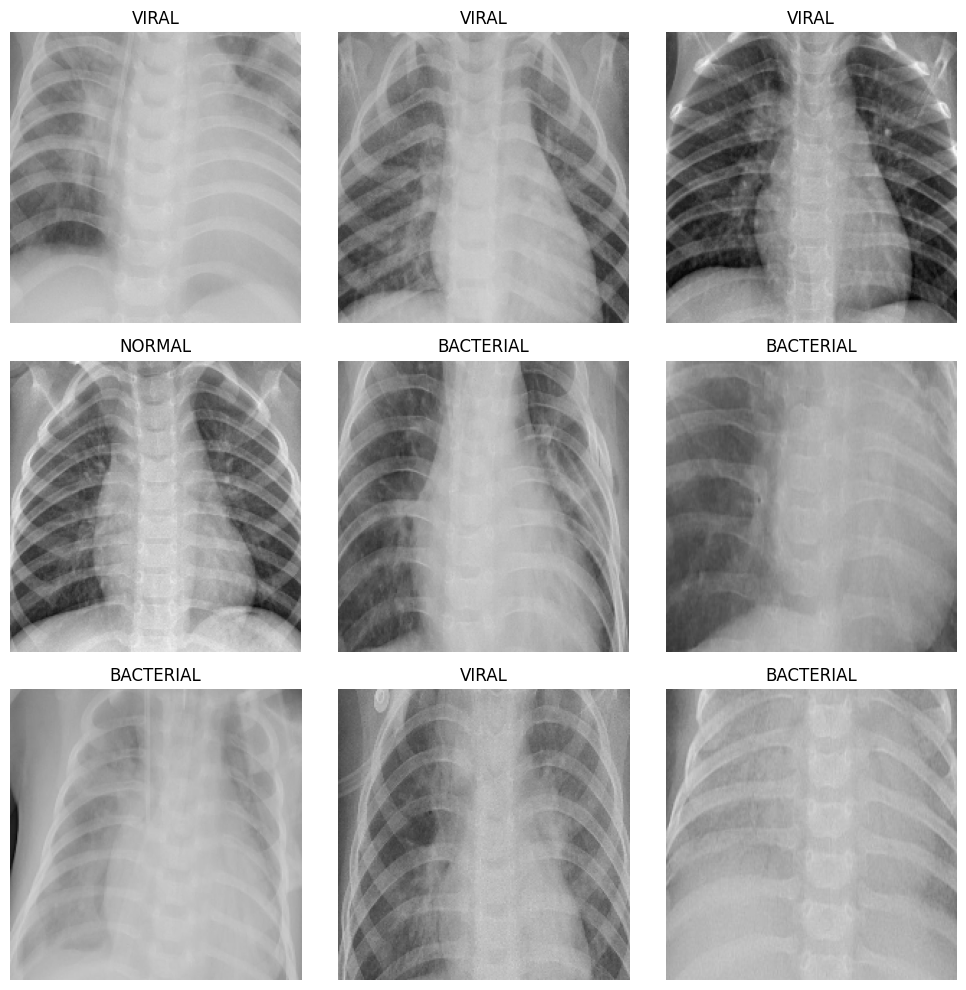

In [ ]:
visualize_random_batch(multi_class_labels, cnr_multi_train_ds)

In [ ]:
base3 = resnet.ResNet101(include_top=False, weights="imagenet", input_shape=CNR_IMG_MULTICLASS_INPUT_SHAPE)
base3.trainable = False

171446536/171446536 [==============================] - 5s 0us/step


In [ ]:
base3.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 202, 202, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 208, 208, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 101, 101, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 101, 101, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [ ]:
def get_multiclass_model() -> keras.Model:
    model = Sequential(
        [
            layers.Input(shape=CNR_IMG_MULTICLASS_INPUT_SHAPE),
            data_augmentation,
            base3,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(3, activation="softmax")
        ]
    )
    start_lr = 0.001
    learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
        start_lr, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model.compile(
        optimizer=optimizers.RMSprop(learning_rate_schedule),
        loss=losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


multiclass_model = get_multiclass_model()

In [ ]:
early_stopping3 = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
history_multi = multiclass_model.fit(
    cnr_multi_train_ds,
    validation_data=cnr_multi_val_ds,
    epochs=50,
    initial_epoch=0,
    callbacks=[early_stopping3]
)

Epoch 1/50
123/123 [==============================] - 71s 472ms/step - loss: 0.5052 - accuracy: 0.7866 - val_loss: 0.5860 - val_accuracy: 0.7590
Epoch 2/50
123/123 [==============================] - 71s 471ms/step - loss: 0.5039 - accuracy: 0.7895 - val_loss: 0.5183 - val_accuracy: 0.7703
Epoch 3/50
123/123 [==============================] - 71s 467ms/step - loss: 0.4927 - accuracy: 0.7930 - val_loss: 0.4965 - val_accuracy: 0.7831
Epoch 4/50
123/123 [==============================] - 63s 407ms/step - loss: 0.5015 - accuracy: 0.7897 - val_loss: 0.5204 - val_accuracy: 0.7598
Epoch 5/50
123/123 [==============================] - 72s 477ms/step - loss: 0.4882 - accuracy: 0.7884 - val_loss: 0.5061 - val_accuracy: 0.7748
Epoch 6/50
123/123 [==============================] - 71s 469ms/step - loss: 0.4842 - accuracy: 0.8010 - val_loss: 0.5085 - val_accuracy: 0.7929
Epoch 7/50
123/123 [==============================] - 69s 457ms/step - loss: 0.4872 - accuracy: 0.7994 - val_loss: 0.5212 - val_ac

In [ ]:
multiclass_model.load_weights("/content/drive/MyDrive/Final_Submission_DL/multiclass_model_ResNet101.keras")

In [ ]:
multiclass_model.evaluate(cnr_multi_test_ds, verbose=1)

20/20 [==============================] - 13s 232ms/step - loss: 0.6674 - accuracy: 0.8125


[0.6673604249954224, 0.8125]

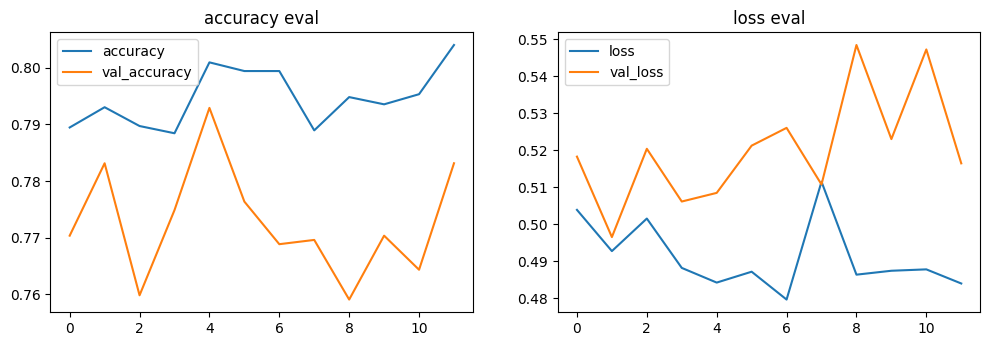

In [ ]:
visualize_model_training_history(history_multi)

# Anomaly Detector

> Load the images, define preprocessing to the image - central cropping, and train generator that holds only healthy chest images.<br>
Add data augmantation to the images.

In [ ]:

# Define a custom preprocessing function to apply tf.image.central_crop
from typing import Tuple
import tensorflow as tf

def custom_preprocessing(image: tf.Tensor) -> tf.Tensor:
    # Apply central crop with central_fraction = 0.8
    image = tf.image.central_crop(image, central_fraction=0.8)
    # Resize the image to match the target size
    image = tf.image.resize(image, [SIZE, SIZE])
    return image

SIZE = 128
batch_size = 32
# Define data generator with validation split and data augmentation
datagen = ImageDataGenerator(
    validation_split=0.1,
    rescale=1./255,  # rescale pixel values to [0,1]
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=custom_preprocessing
)
train_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/chest_xray/train',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    classes=['NORMAL'],
    subset='training'  # Specify subset as 'training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/chest_xray/train',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    classes=['NORMAL'],
    subset='validation'  # Specify subset as 'validation'
)

anomaly_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/chest_xray/train',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    classes=['PNEUMONIA']
)


Found 1207 images belonging to 1 classes.
Found 134 images belonging to 1 classes.
Found 3875 images belonging to 1 classes.


## Define the Autoencoder
The encoder component accepts an image as input and transforms it into a latent space representation, which is significantly smaller in size compared to the input image. Subsequently, the decoder component takes this representation and endeavors to reconstruct the original image, aiming to produce an output image as similar as possible to the input image.<br> We used Mean squared error loss (the loss is between the original image and the reconstruced image), and adam optimizer.

In [ ]:
#Define the autoencoder.

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 16)       

> Train the model only on the healthy images

In [ ]:
import os
model_path = '/content/drive/MyDrive/chest_xray/encoder_decoder_weights_final.h5'


# Check if the weights file exists
if os.path.exists(model_path):
    # Load the weights into the model
    model.load_weights(model_path)
    print("Weights loaded successfully.")
else:
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=250,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle=True)

    # Save the weights to a file
    model.save_weights(model_path)
    print("Weights saved.")

# Plot the training and validation loss
if 'history' in locals():
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Weights loaded successfully.


> visualize the reconstructed image

1/1 [==============================] - 1s 539ms/step


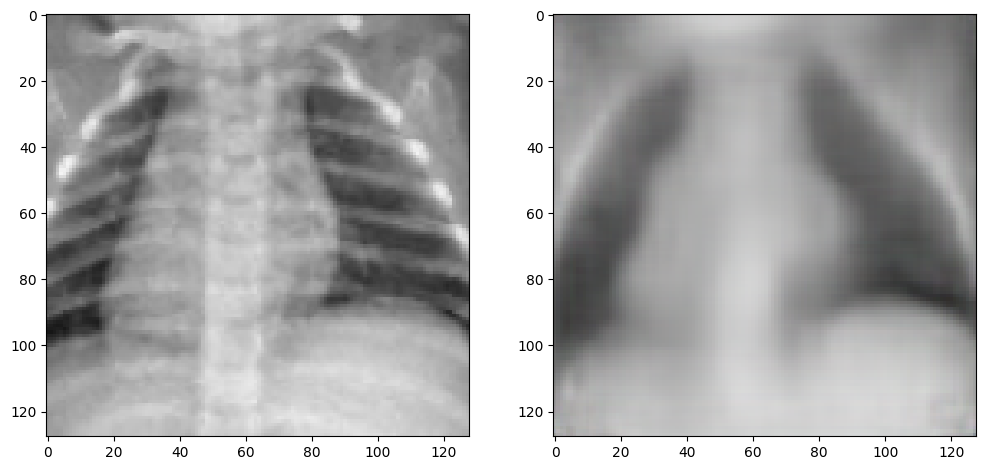

1/1 [==============================] - 0s 28ms/step


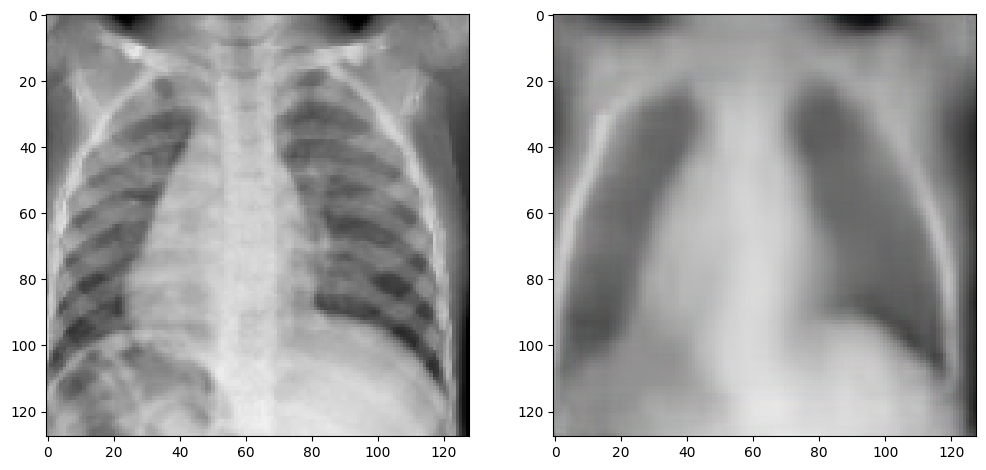

In [ ]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model.
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images


#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()


# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model.
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= anomaly_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images


#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()



> evaluate the model by calculates the Recon. error for the validation (normal) images and the anomaly images. Our expectation is to see low Recon. error for the normal images, and higher Recon. error for the sick images, but instead we got the opposite.


In [ ]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

Recon. error for the validation (normal) data is:  [0.0035718469880521297, 0.0035718469880521297]
Recon. error for the anomaly data is:  [0.0022715753875672817, 0.0022715753875672817]


In [ ]:
#Calculate reconstruction error to find their means values for health and anomaly images.
#We use these mean and sigma to set thresholds.
def calc_recon_error(batch_images: np.ndarray) -> Tuple[float, float]:

    # density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):

        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        recon_error_list.append(reconstruction_error)


    average_recon_error = np.mean(np.array(recon_error_list))
    stdev_recon_error = np.std(np.array(recon_error_list))

    return average_recon_error, stdev_recon_error

In [ ]:
#For this let us generate a batch of images for each.
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_recon_error(train_batch)
anomaly_values = calc_recon_error(anomaly_batch)

In [ ]:
print("healthy images' mean and std dev MSE: ")
print(uninfected_values)
print("sick images' mean and std dev MSE: ")
print(anomaly_values)


healthy images' mean and std dev MSE: 
(0.004010008460271263, 0.0008194710145356123)
sick images' mean and std dev MSE: 
(0.002712261495030215, 0.0008339219552852451)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate reconstruction errors for all images in train_generator
def calc_reconstruction_errors(generator):
    reconstruction_errors = []
    num_batches = len(generator)

    for i in range(num_batches):
        batch_images = generator[i][0]
        batch_errors = calc_recon_error(batch_images)
        reconstruction_errors.extend(batch_errors)

    return reconstruction_errors

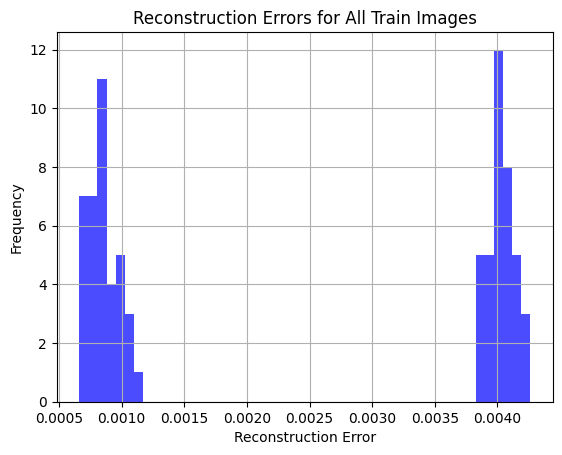

In [ ]:
import os
import sys

# Save original stdout
original_stdout = sys.stdout

# Redirect stdout to null device
sys.stdout = open(os.devnull, 'w')

# Calculate reconstruction errors for all images in train_generator
all_train_recon_errors = calc_reconstruction_errors(train_generator)

# Restore stdout
sys.stdout = original_stdout

# Plot histogram of reconstruction errors for all train images
plt.hist(all_train_recon_errors, bins=50, color='blue', alpha=0.7)
plt.title('Reconstruction Errors for All Train Images')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

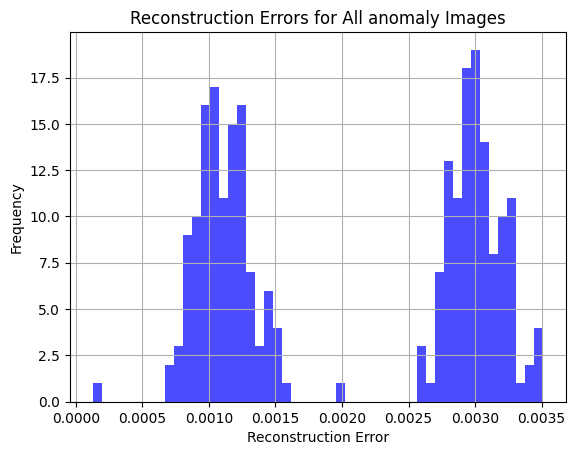

In [ ]:
# # Calculate reconstruction errors for all images in train_generator
# all_anomal_recon_errors = calc_reconstruction_errors(anomaly_generator)
import os

import sys

# Save original stdout
original_stdout = sys.stdout

# Redirect stdout to null device
sys.stdout = open(os.devnull, 'w')

# Calculate reconstruction errors for all images in anomaly_generator
all_anomal_recon_errors = calc_reconstruction_errors(anomaly_generator)

# Restore stdout
sys.stdout = original_stdout
# Plot histogram of reconstruction errors for all anomaly images
plt.hist(all_anomal_recon_errors, bins=50, color='blue', alpha=0.7)
plt.title('Reconstruction Errors for All anomaly Images')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Using the Anomaly Detector

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob, random

# Function to check if an image is an anomaly or not
def check_anomaly(img_path: str) -> None:
    # Reconstruction error threshold
    reconstruction_error_threshold = 0.0035

    # Open and preprocess the image
    img = Image.open(img_path)
    img = img.resize((128, 128), Image.ANTIALIAS)

    # Convert the image to a NumPy array
    img = np.array(img)

    # If the image is grayscale, convert it to RGB
    if len(img.shape) == 2:
        img = np.stack((img,) * 3, axis=-1)

    # Normalize the image
    img = img / 255.

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    # Predict the reconstruction of the image
    reconstruction = model.predict(img)
    reconstruction_error = model.evaluate(reconstruction, img, batch_size=1)[0]

    # Check if the reconstruction error exceeds the threshold
    if reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
    else:
        print("The image is NORMAL")

In [ ]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob, random
para_file_paths = glob.glob('/content/drive/My Drive/chest_xray/test/PNEUMONIA/*')
uninfected_file_paths = glob.glob('/content/drive/My Drive/chest_xray/test/NORMAL/*')

# Select a random anomaly image path
anomaly_image_path = random.choice(para_file_paths)
print("Anomaly Image Path:", anomaly_image_path)
check_anomaly(anomaly_image_path)

# Select a random normal image path
normal_image_path = random.choice(uninfected_file_paths)
print("Normal Image Path:", normal_image_path)
check_anomaly(normal_image_path)

Anomaly Image Path: /content/drive/My Drive/chest_xray/test/PNEUMONIA/person128_bacteria_608.jpeg
1/1 [==============================] - 0s 24ms/step - loss: 0.0049 - mse: 0.0049
The image is an anomaly
Normal Image Path: /content/drive/My Drive/chest_xray/test/NORMAL/NORMAL2-IM-0292-0001.jpeg
1/1 [==============================] - 0s 23ms/step - loss: 0.0065 - mse: 0.0065
The image is an anomaly


# Classifying a new image using embedding vector and KNN

> Feed a dataset to the model. <br>
Returns an embedding vector from it's one before the last layer.

In [ ]:
def embedding_vectors_from_model(
    model: keras.Model, dataset: tf.data.Dataset
) -> np.ndarray:
    emd_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    emd_vec = emd_model.predict(dataset, verbose=0)
    emd_vec = np.squeeze(emd_vec)
    return emd_vec

> Separate a dataset into X (Samples) and y (labels).

In [ ]:
def separate_X_y_dataset(dataset: tf.data.Dataset) -> tuple[np.ndarray, np.ndarray]:
    X = []
    Y = []
    for x, y in dataset:
        X.append(x.numpy())
        Y.append(y.numpy())

    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    return X, Y

> Generate a KNN classifier using X, y (Samples, labels).

In [ ]:
def create_KNN_from_X_y(
    n_neighbors: int, X: np.ndarray, y: np.ndarray
) -> KNeighborsClassifier:
    knn_classifier = KNeighborsClassifier(n_neighbors)
    knn_classifier.fit(X, y)
    return knn_classifier

> Gets a model, knn classifier object and an image np.ndarray. <br>
The function calculate the corresponding image embedding vector from the model, <br>
and returns it with the knn classifier prediction of it.

In [ ]:
def classify_new_image_emd_KNN(
    model: keras.Model, knn_classifier: KNeighborsClassifier, image: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    if len(image.shape) > 3:
        emd_vec = embedding_vectors_from_model(model, image)
        return emd_vec, knn_classifier.predict(emd_vec)
    else:
        emd_vec = embedding_vectors_from_model(model, np.expand_dims(image, axis=0))
        emd_vec = np.expand_dims(emd_vec, axis=0)
        return emd_vec, knn_classifier.predict(emd_vec)

> Gets the reduced vector (after applying t-SNE algorithm), train labels and the string labels from the KNN classifier model.<br>
Draws the t-SNE for it plot.

In [ ]:
def plot_TSNE_reduced_vector(
    reduced_emd_vec: np.ndarray,
    train_labels: np.ndarray,
    labels: list[str]
):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection="3d")

    unique_labels = np.unique(train_labels, axis=0)
    for lbl in unique_labels:
      filtered_idxes = train_labels == lbl
      if len(labels) > 2:
        filtered_idxes = np.all(train_labels == lbl, axis=1)
      # filtered_idxes = np.all(train_labels[:, np.newaxis] == lbl, axis=1)

      color = np.random.rand(3,)

      # Plotting training images
      ax.scatter(
          reduced_emd_vec[filtered_idxes, 0],
          reduced_emd_vec[filtered_idxes, 1],
          reduced_emd_vec[filtered_idxes, 2],
          c=color,
          marker="o",
          alpha=0.65,
          label=labels[lbl.argmax()] if len(labels) > 2 else labels[lbl],
      )


    ax.legend()
    ax.set_title("t-SNE Visualization of Training Embedding Space")

    plt.show()

## t-SNE for binary model

> split the dataset into binary_test_images, binary_test_labels

In [ ]:
binary_test_images, binary_test_labels = separate_X_y_dataset(cnr_test_ds)
binary_train_images, binary_train_labels = separate_X_y_dataset(cnr_train_ds)

In [ ]:
binary_train_emd_vec = embedding_vectors_from_model(binary_model, binary_train_images)
binary_knn_classifier = create_KNN_from_X_y(
    n_neighbors=7, X=binary_train_emd_vec, y=binary_train_labels
)

In [ ]:
binary_knn_classifier = joblib.load("/content/drive/MyDrive/Final_Submission_DL/binary_knn_classifier.joblib")

In [ ]:
joblib.dump(binary_knn_classifier, "binary_knn_classifier.joblib")

['binary_knn_classifier.joblib']

In [ ]:
# let's take a random image and get his embedding vector and his prediciton using the knn classifier
binary_image_emd_vec, binary_image_predicted_label = classify_new_image_emd_KNN(
    binary_model, binary_knn_classifier, binary_test_images[150]
)

In [ ]:
# print the result from the knn classifier
print("True label:", binary_test_labels[150])
print("Predicted label:", binary_image_predicted_label[0])

True label: 1
Predicted label: 1


In [ ]:
# calculate the accuracy of the binary knn
_, binary_test_pred_labels = classify_new_image_emd_KNN(
    binary_model, binary_knn_classifier, binary_test_images
)

print(skmetrics.accuracy_score(binary_test_labels, binary_test_pred_labels))

0.8076923076923077


In [ ]:
# visiluaze the train emmbedding vectors over 3d-space using T-sne
tsne = TSNE(n_components=3, random_state=42)
binary_reduced_emd_vec = tsne.fit_transform(
    binary_train_emd_vec
)

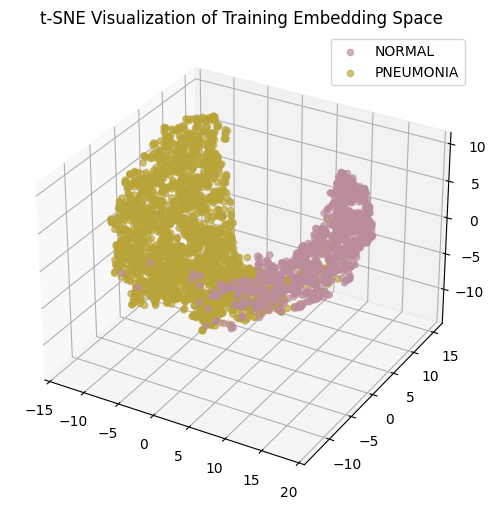

In [ ]:
plot_TSNE_reduced_vector(binary_reduced_emd_vec, binary_train_labels, labels)

## t-SNE for multiclass model

In [ ]:
multi_test_images, multi_test_labels = separate_X_y_dataset(cnr_multi_test_ds)
multi_train_images, multi_train_labels = separate_X_y_dataset(cnr_multi_train_ds)

In [ ]:
multi_train_emd_vec = embedding_vectors_from_model(multiclass_model, multi_train_images)
multi_knn_classifier = create_KNN_from_X_y(
    n_neighbors=5, X=multi_train_emd_vec, y=multi_train_labels
)

In [ ]:
multi_knn_classifier = joblib.load("/content/drive/MyDrive/Final_Submission_DL/multi_knn_classifier.joblib")

In [ ]:
joblib.dump(multi_knn_classifier, "multi_knn_classifier.joblib")

['multi_knn_classifier.joblib']

In [ ]:
multi_image_emd_vec, multi_image_predicted_label = classify_new_image_emd_KNN(
  multiclass_model, multi_knn_classifier, multi_test_images[150]
)

In [ ]:
print("True label:", multi_test_labels[150])
print("Predicted label:", multi_image_predicted_label)

True label: [0. 0. 1.]
Predicted label: [[0. 0. 1.]]


In [ ]:
# calculate the accuracy of the multi-class knn
_, multi_test_pred_labels = classify_new_image_emd_KNN(
    multiclass_model, multi_knn_classifier, multi_test_images
)

print(skmetrics.accuracy_score(multi_test_labels, multi_test_pred_labels))

0.7227564102564102


In [ ]:
tsne = TSNE(n_components=3, random_state=42)
multi_reduced_emd_vec = tsne.fit_transform(
    multi_train_emd_vec
)

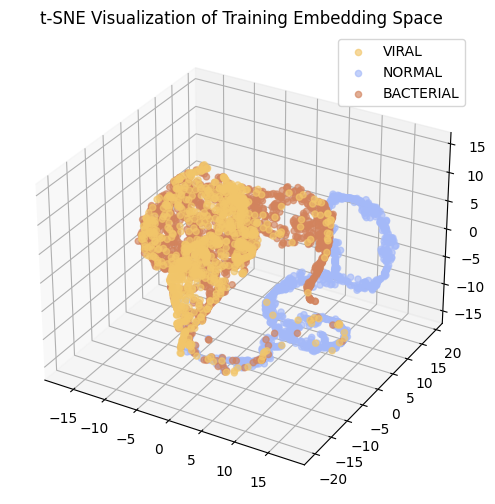

In [ ]:
plot_TSNE_reduced_vector(multi_reduced_emd_vec, multi_train_labels, multi_class_labels)